## Vessel Segmentation

In this notebook we will use convolutional neural networks to compute 3D blood vessel segmentations.

The way we do this is use the vessel path information to compute a series of 2D cross sectional images along the vessel.

We then use a 2D convolutional neural network to segment each 2D cross section. Using the vessel path information, we can then replace the 2D segmentations into 3D space to create a full 3D vessel segmentation.

In [1]:
import pandas as pd
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt

plt.figure()
plt.close()

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams.update({'font.size': 22})

## Loading the Neural Network

We have uploaded our machine learning code to the AHA precision medicine platform, along with all pretrained neural networks we used.

We now load one of the networks and prepare to segment vessels for a particular medical image.

Each neural network is specified by a configuriation file. These are located in /seg_regression/config/.

By specifiying a particular configuration file we can load one of the networks. We additionally load an image preprocessor object and neural network prediction postprocessor object to make working with the network easier.

In [4]:
from modules import io

config_file = './config/googlenet_train150k_clean.yaml'
config = io.load_yaml(config_file)

In [5]:
import factories.model_factory as model_factory

model = model_factory.get(config)
model.load()

pool 1 Tensor("googlenet/max_pool:0", shape=(?, 79, 79, 64), dtype=float32)
pool_2 Tensor("googlenet/max_pool_1:0", shape=(?, 39, 39, 192), dtype=float32)
pool 3 Tensor("googlenet/max_pool_2:0", shape=(?, 19, 19, 480), dtype=float32)
pool side Tensor("googlenet/avg_pool:0", shape=(?, 5, 5, 833), dtype=float32)
[None, 3200]
[None, 1024]
pool 5 Tensor("googlenet/max_pool_3:0", shape=(?, 9, 9, 833), dtype=float32)
pool final Tensor("googlenet/avg_pool_1:0", shape=(?, 3, 3, 1024), dtype=float32)
[None, 9216]
[None, 1024]
Tensor("googlenet/output/Identity:0", shape=(?, 15), dtype=float32)
Tensor("googlenet/side_output/Identity:0", shape=(?, 15), dtype=float32)
INFO:tensorflow:Restoring parameters from ./results/googlenet_train150k_clean/model/googlenet


In [6]:
import factories.preprocessor_factory as preprocessor_factory

preprocessor = preprocessor_factory.get(config)

In [7]:
import factories.postprocessor_factory as postprocessor_factory

postprocessor = postprocessor_factory.get(config)

## Loading and Preparing Image Data

Similar to the explore_vascular_data notebook, here we again load one of the images from the vascular model repository and prepare it to extract 2D slices along different planar directions.

Each neural network has been trained with a specific pixel spacing and window size, so here we set the SPACING and RESLICE_EXTENT variables according to the specified configuration file.

In [8]:
from modules import sv_image, vascular_data
import numpy as np

In [9]:
SPACING        = config['SPACING']
IMAGE          = "OSMSC0110"
RESLICE_EXTENT = config['CROP_DIMS']
REAL_EXT       = config['CROP_DIMS']/2*config['SPACING']

image_path = './data/images/{}/image.mha'.format(IMAGE)
seg_path   = './data/images/{}/segmentation.mha'.format(IMAGE)
paths_path = './data/images/{}/paths.paths'.format(IMAGE)

In [10]:
image_sv = sv_image.Image(image_path)
image_sv.set_spacing(SPACING)
image_sv.set_reslice_ext(RESLICE_EXTENT)

seg_sv   = sv_image.Image(seg_path)
seg_sv.set_spacing(SPACING)
seg_sv.set_reslice_ext(RESLICE_EXTENT)

## Loading Vessel Paths

Similar to the explore_vascular_data notebook here we load the vessel path information.

The vessels are listed by id and name.

We select one of the vessels, extract 2D cross sectional image slices along the vessel and feed these to the neural network. The neural network outputs the corresponding vessel segmentation for that slice.

We display the segmentations in 2D followed by an interactive 3D visualization. Use your mouse to rotate the camera in the 3D view.

To select a different vesse lchange the PATH_ID variable below, note that it must be a string.

In [11]:
vessel_paths = vascular_data.parsePathFile(paths_path) 

In [12]:
print('vessel path ids and names')
for k in vessel_paths:
    print("path_id={}, name={}".format(k, vessel_paths[k]['name']))

vessel path ids and names
path_id=113, name=superior_mesenteric
path_id=105, name=left_iliac_branch1
path_id=118, name=left_sup_renal
path_id=115, name=right_rental
path_id=108, name=celiac_trunk
path_id=102, name=right_iliac_internal
path_id=107, name=left_iliac_branch2
path_id=100, name=aorta
path_id=117, name=right_inf_renal
path_id=110, name=splenic_branch1
path_id=109, name=splenic
path_id=119, name=inferior_mesenteric_artery
path_id=114, name=superior_mesenteric_branch1
path_id=111, name=celiac_trunk_branch1
path_id=104, name=right_iliac_branch1
path_id=101, name=right_iliac
path_id=106, name=right_iliac_branch2
path_id=116, name=left_rental
path_id=103, name=left_iliac_internal


In [13]:
PATH_ID  = "101"
path     = vessel_paths[PATH_ID]
name     = path['name']
points   = path['points']
n_points = len(points)

print("path {} has {} points".format(name, n_points))

path right_iliac has 200 points


right_iliac path point 0


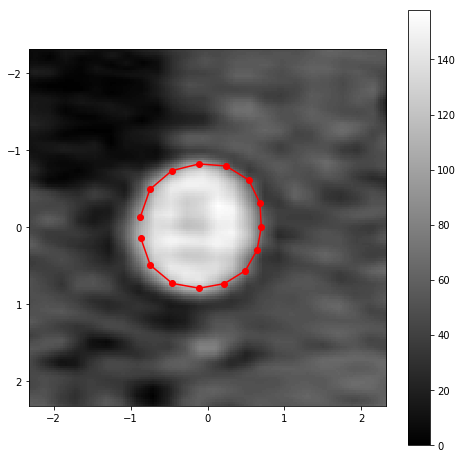

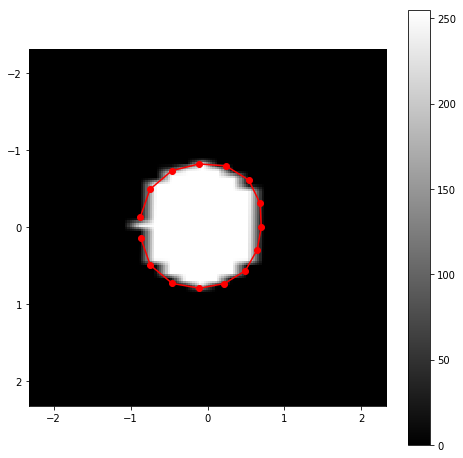

right_iliac path point 10


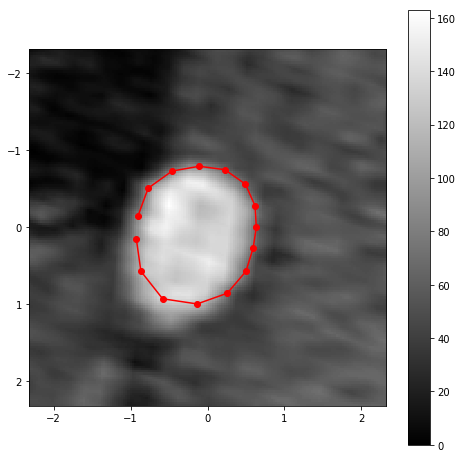

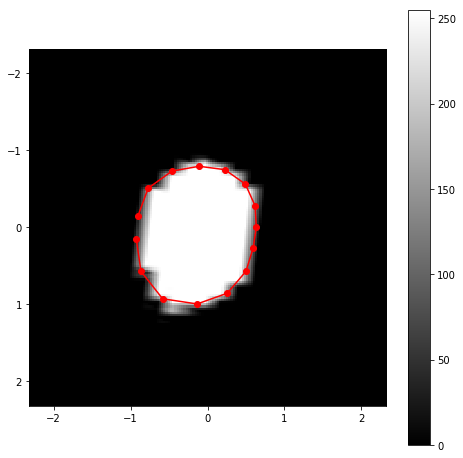

right_iliac path point 20


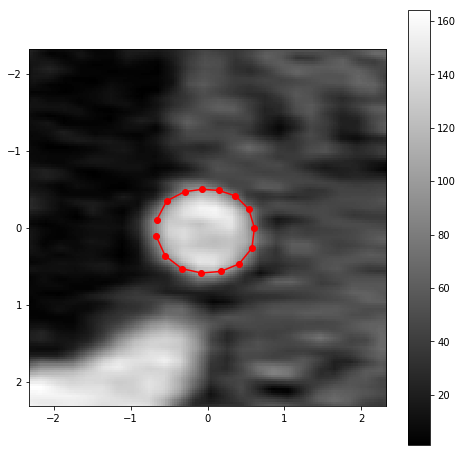

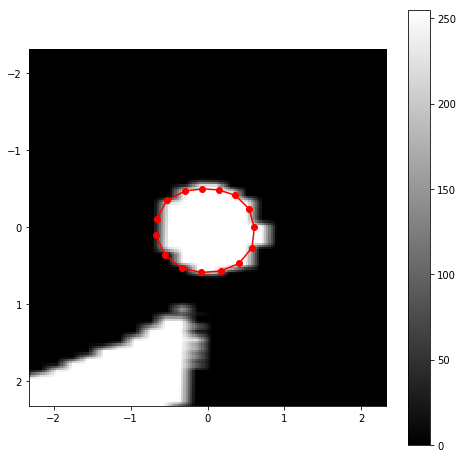

right_iliac path point 30


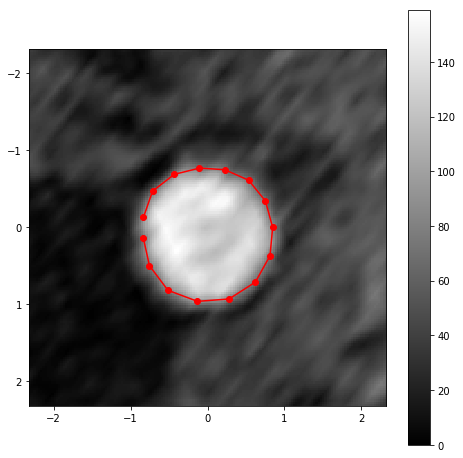

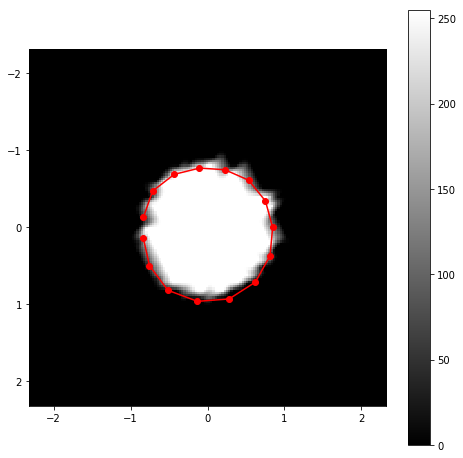

right_iliac path point 40


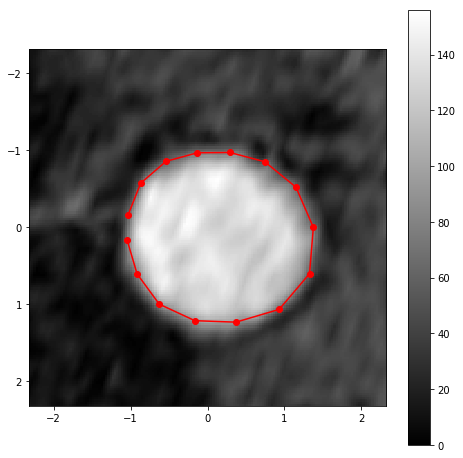

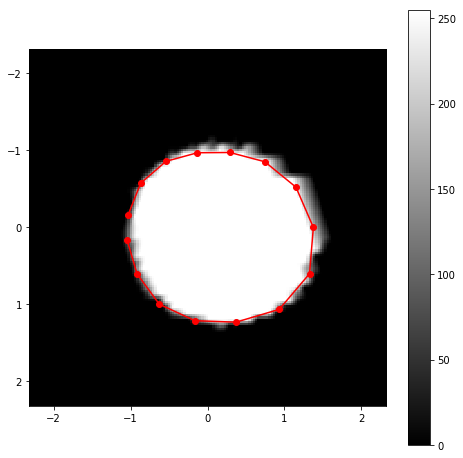

right_iliac path point 50


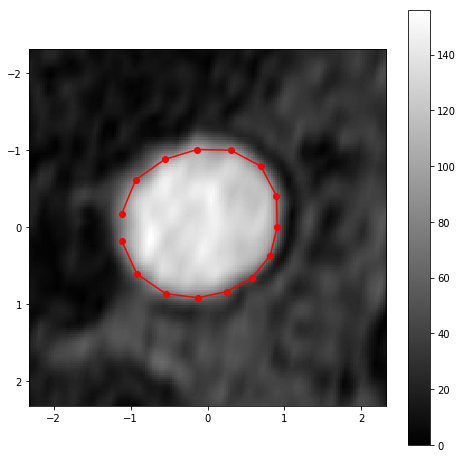

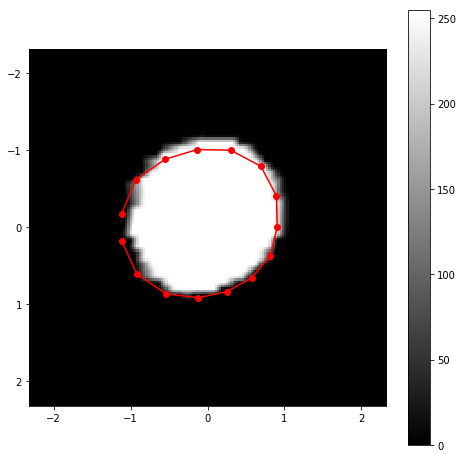

right_iliac path point 60


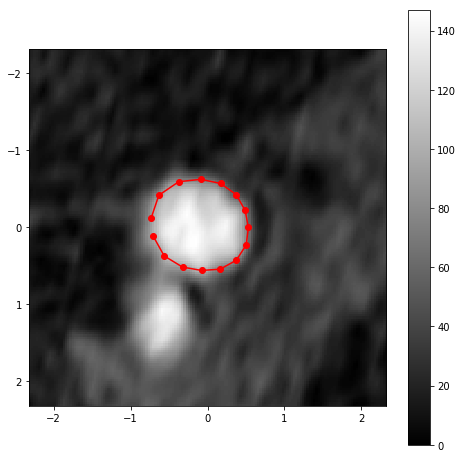

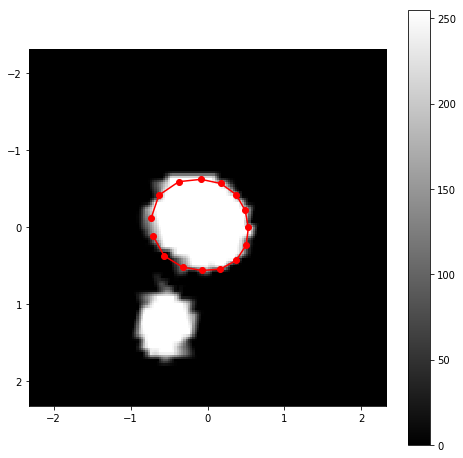

right_iliac path point 70


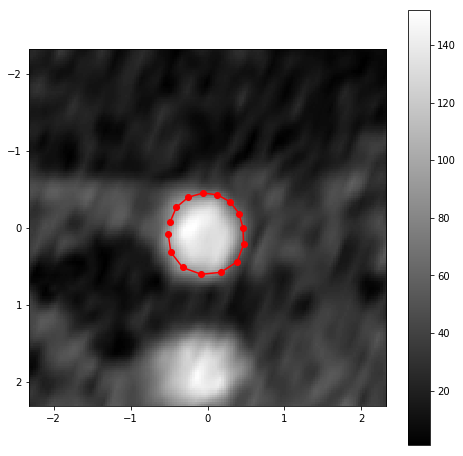

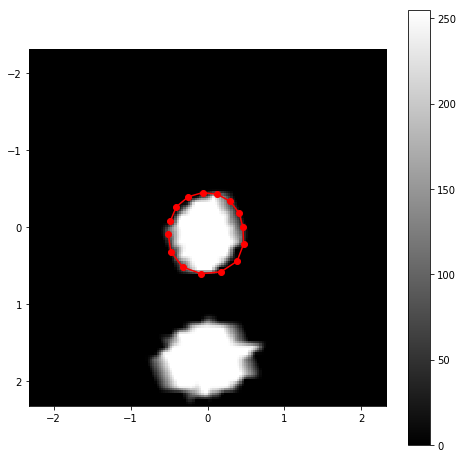

right_iliac path point 80


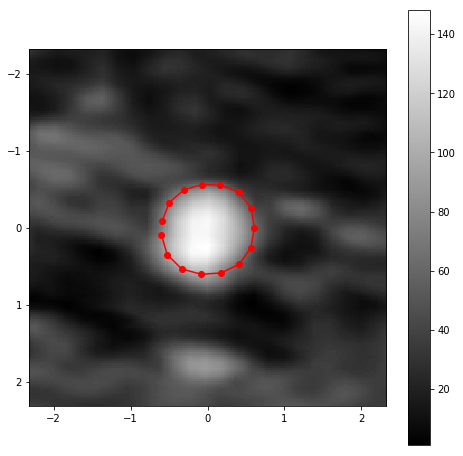

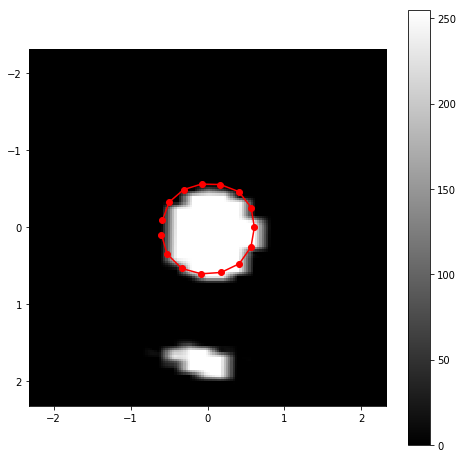

right_iliac path point 90


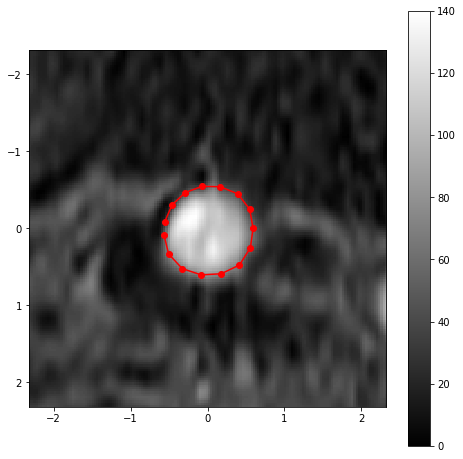

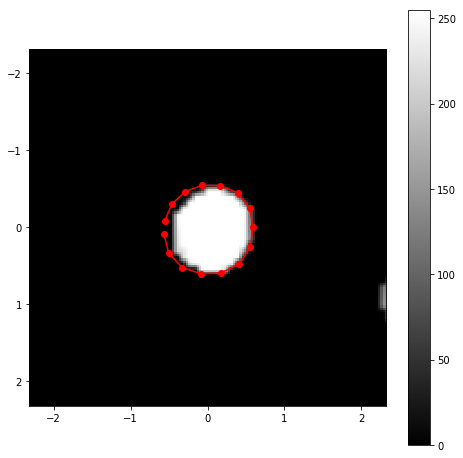

right_iliac path point 100


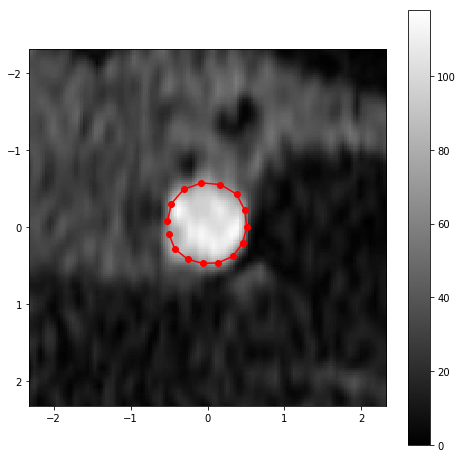

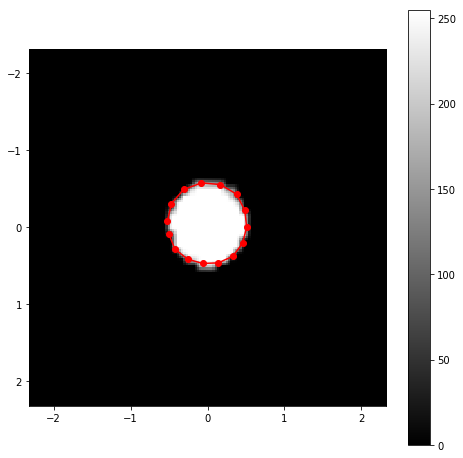

right_iliac path point 110


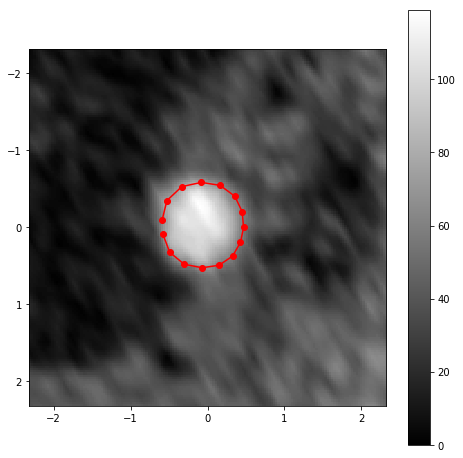

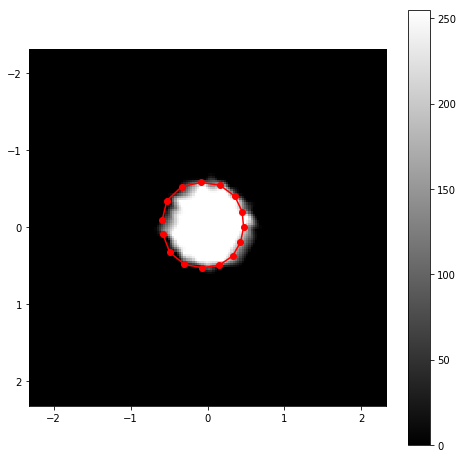

right_iliac path point 120


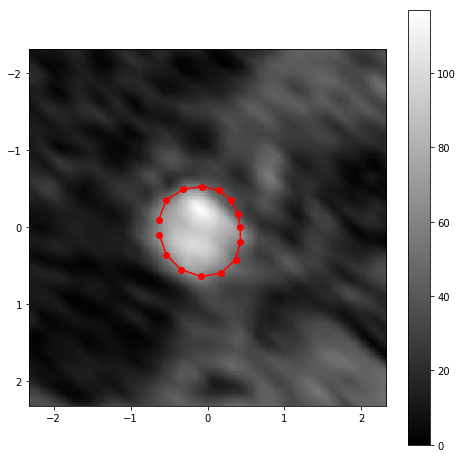

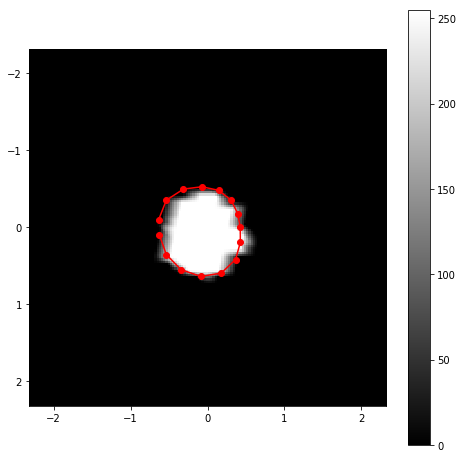

right_iliac path point 130


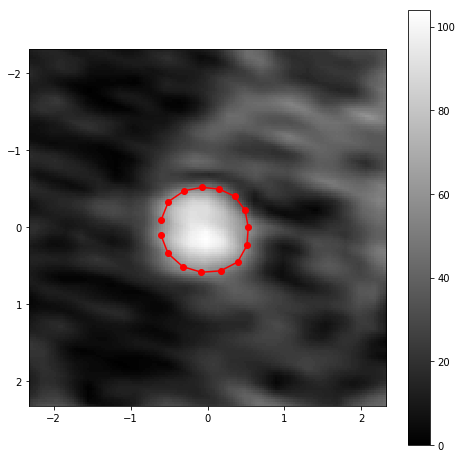

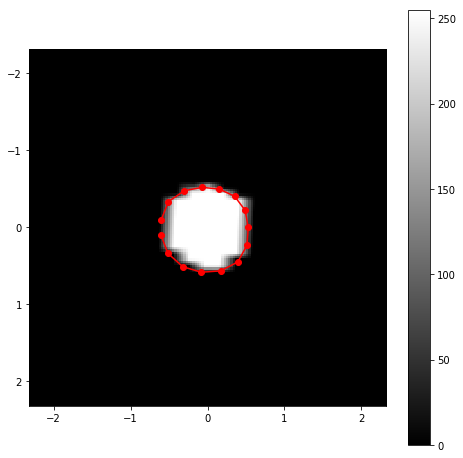

right_iliac path point 140


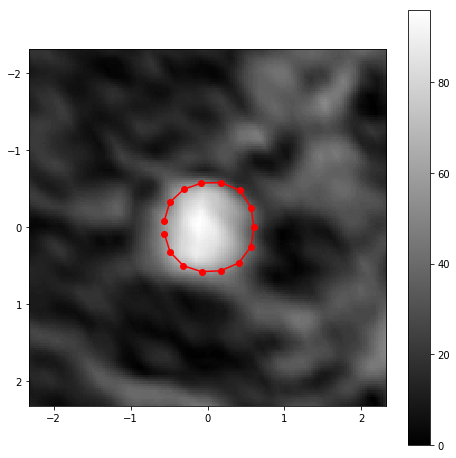

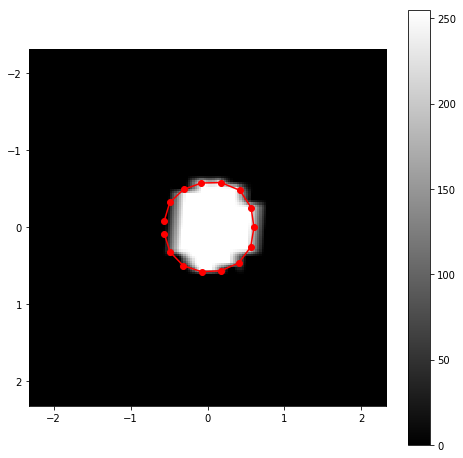

right_iliac path point 150


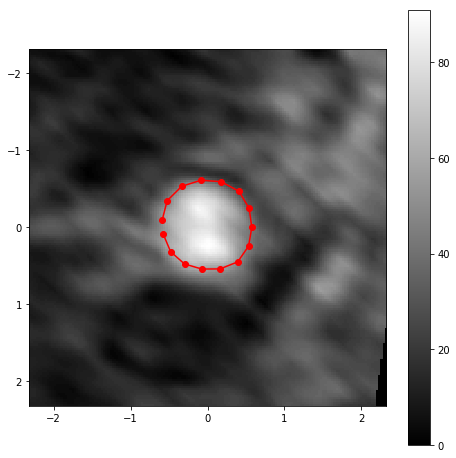

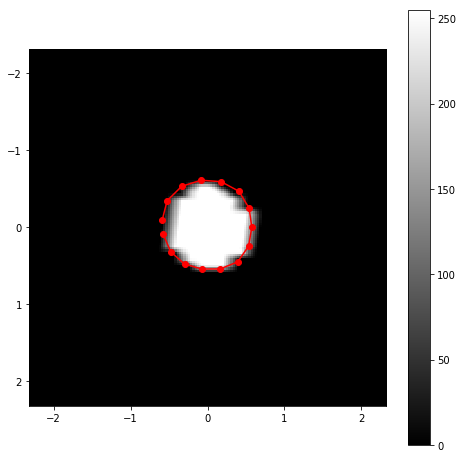

right_iliac path point 160


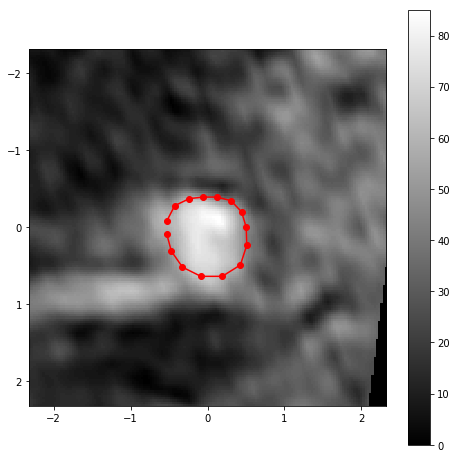

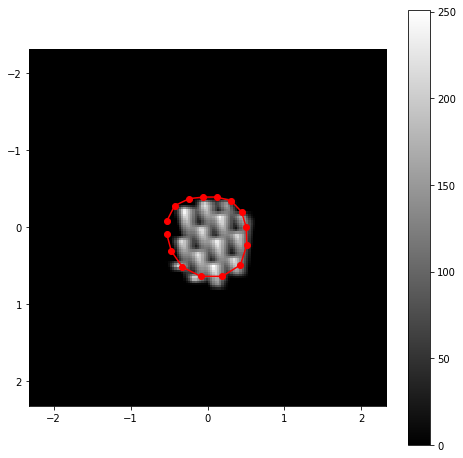

right_iliac path point 170


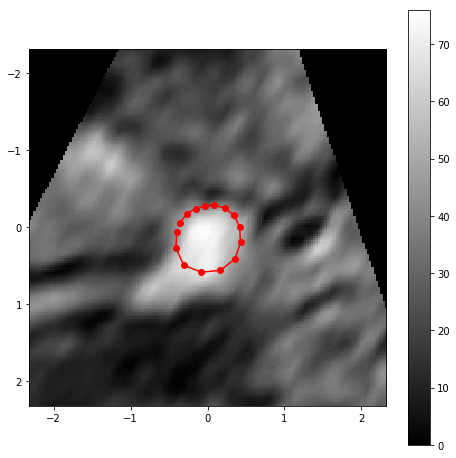

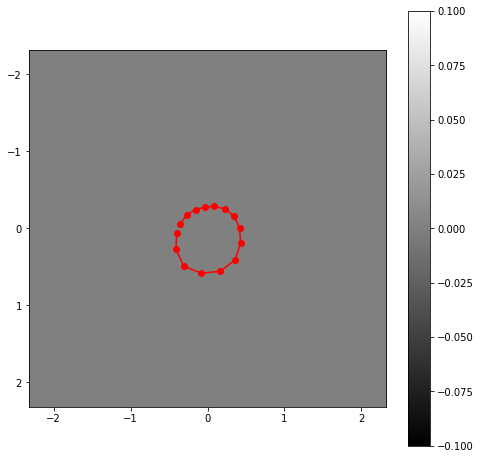

right_iliac path point 180


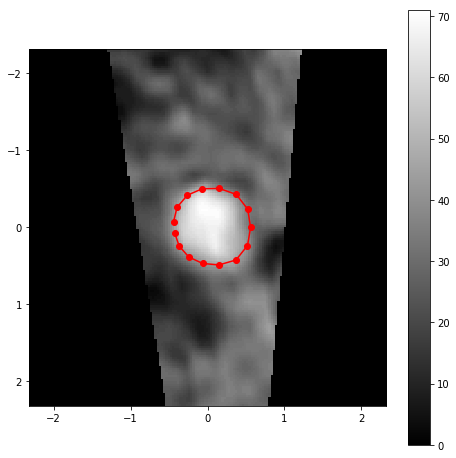

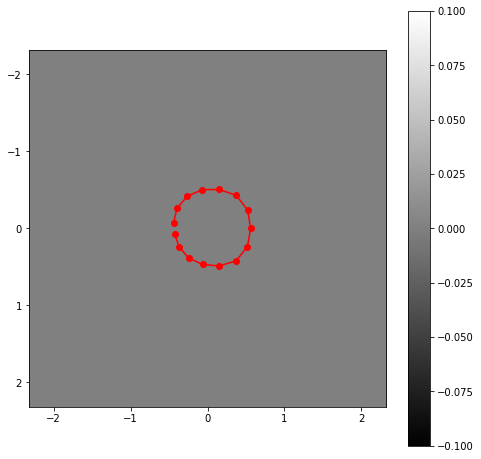

right_iliac path point 190


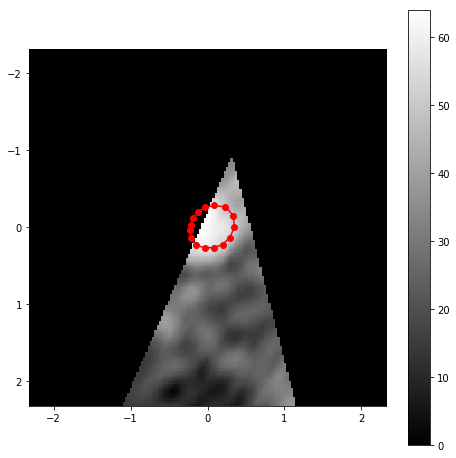

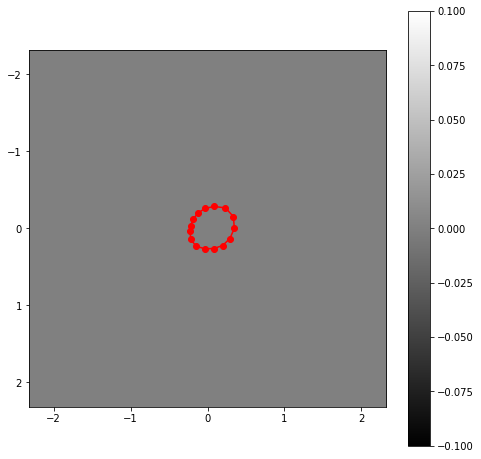

In [14]:
%matplotlib inline
INTERVAL = 10

contours_3d = []

for i in range(0, n_points, INTERVAL):
    print("{} path point {}".format(name,i))
    point = points[i]
    
    p = point[:3]
    n = point[3:6]
    v = point[6:9]
    
    x = image_sv.get_reslice(p,n,v)
    y = seg_sv.get_reslice(p,n,v)

    x_input      = preprocessor(x)
    
    yhat         = model.predict(x_input)
    
    pred_contour = postprocessor(yhat)
    
    c3d = vascular_data.denormalizeContour(pred_contour, p, n, v)
    contours_3d.append(c3d)
    
    plt.figure(figsize=(8,8))
    plt.imshow(x, extent=[-REAL_EXT,REAL_EXT,REAL_EXT,-REAL_EXT], cmap='gray')
    plt.colorbar()
    plt.plot(pred_contour[:,0], pred_contour[:,1], color='r', marker='o')
    plt.show()

    plt.figure(figsize=(8,8))
    plt.imshow(y, extent=[-REAL_EXT,REAL_EXT,REAL_EXT,-REAL_EXT], cmap='gray')
    plt.colorbar()
    plt.plot(pred_contour[:,0], pred_contour[:,1], color='r', marker='o')
    plt.show()

<IPython.core.display.Javascript object>


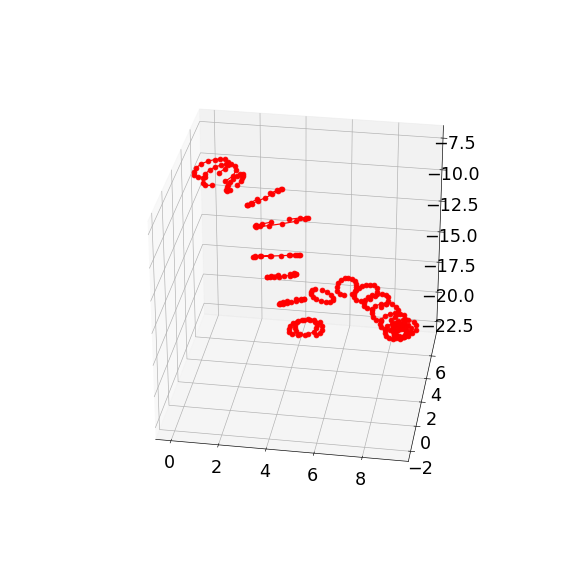

In [16]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

for c in contours_3d:
    ax.plot3D(c[:,0], c[:,1], c[:,2], color='r', marker='o')
    
plt.show()